In [1]:
from collections import namedtuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from vorpy.symplectic_integration.nonseparable_hamiltonian import integrate, heuristic_estimate_for_omega
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from cgc.graph import ComputationalGraph, derivative
from cgc.optimizers import TwoStepsNGDptimizerForKF
from cgc.utils import KernelParameter as KP

from jax import config
config.update("jax_enable_x64", True)
pd.set_option("display.precision", 17)


In [2]:
def get_hamiltonian_from(graph: ComputationalGraph, Z):
    """Retunr a callable for the learned hamiltonina from CGC."""
    H_fn = graph._unknown_functions["H"]
    return lambda pq: H_fn._f(pq, H_fn.parameter(Z), H_fn.observation(Z))


In [3]:
def get_pq_from(graph: ComputationalGraph, Z):
    _, size = Z.shape
    dims = (size - 2) // 2

    p_fns = [graph._unknown_functions[f"p{index + 1 if dims > 1 else ''}"] for index in range(dims)]
    q_fns = [graph._unknown_functions[f"q{index + 1 if dims > 1 else ''}"] for index in range(dims)]   

    def pq_fn(t):
        ps = [p_fn._f(t, p_fn.parameter(Z), p_fn.observation(Z)) for p_fn in p_fns]
        qs = [q_fn._f(t, q_fn.parameter(Z), q_fn.observation(Z)) for q_fn in q_fns]

        return jnp.hstack(ps + qs)

    return pq_fn

In [4]:
def __reduce_mask(nd_mask):
        reduced_mask = nd_mask
        if nd_mask.ndim > 1:
            reduced_mask = np.multiply.reduce(nd_mask, axis=1).astype(bool)
        return reduced_mask

def two_steps_initialization(graph: ComputationalGraph, X, M, observations_end):

    _, pq_size = X.shape

    true_observations_mask = __reduce_mask(M[:observations_end, 1:pq_size - 1])

    H_est = get_hamiltonian_from(graph, X[:observations_end, :][true_observations_mask])
    pq_est = get_pq_from(graph, X[:observations_end, :][true_observations_mask])
    H_grad = jax.jit(jax.grad(H_est))

    def ms_kernel_ode(pq, t):
        dims = (pq_size - 2) // 2
        grad_val = H_grad(pq)
        dpH = grad_val[0: dims]
        dqH = grad_val[dims: 2 * dims]

        return np.concatenate([-dqH, dpH])

    init_point = X[observations_end - 1, 1:pq_size - 1]

    t = X[:, 0]
    pq_2s = odeint(ms_kernel_ode, init_point, t[observations_end - 1:])
    pq_interpolated = jax.jit(jax.vmap(pq_est))(t[:observations_end])

    X_initialized = X.copy()
    X_initialized[observations_end - 1:, 1:pq_size - 1] = pq_2s
    X_initialized[:observations_end, 1:pq_size - 1][~true_observations_mask] = pq_interpolated[~true_observations_mask, :]
    H_init = jax.jit(jax.vmap(H_est))(X_initialized[:, 1:pq_size - 1])
    X_initialized[:, pq_size - 1] = H_init

    _, separate_losses = graph._loss(X_initialized, X_initialized, M, return_separate=True)
    rkhs_order_magnitude = np.floor(np.log10(separate_losses.get("rkhs_norm")))
    unk_funcs_order_magnitude = np.floor(np.log10(separate_losses.get("unknown_funcs_loss")))
    constraints_order_magnitude = np.floor(np.log10(separate_losses.get("constraints_loss")))
    data_compliance_order_magnitude = np.floor(np.log10(separate_losses.get("data_compliance_loss")))

    unknown_functions_loss_multiplier = 10 ** (rkhs_order_magnitude - unk_funcs_order_magnitude)
    constraint_loss_multiplier = 10 ** (rkhs_order_magnitude - constraints_order_magnitude)
    data_compliance_loss_multiplier = 10 ** (rkhs_order_magnitude - data_compliance_order_magnitude)

    return X_initialized, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier


In [5]:
def run_kflow_for__(graph: ComputationalGraph, X, M, observations_end):

    _, pq_size = X.shape

    true_observations_mask = __reduce_mask(M[:observations_end, 1:pq_size - 1])

    graph.set_uknknow_fns_parameters_range()
    optimizer = TwoStepsNGDptimizerForKF(graph._total_kflow_loss)


    params, trainable_mask, weights_mask = graph._gather_parameters()
    new_params = optimizer.run(params, X[:observations_end, :][true_observations_mask],  M, original_params=params, trainable_mask=trainable_mask, sparse_mask=weights_mask)
    graph._scatter_parameters(new_params)

    graph.report_kernel_params()

In [6]:
def run_kflow_for(graph: ComputationalGraph, X, M, observations_end):

    _, pq_size = X.shape

    true_observations_mask = __reduce_mask(M[:observations_end, 1:pq_size - 1])

    graph.set_uknknow_fns_parameters_range()

    for _, fn in graph._unknown_functions.items():
        optimizer = TwoStepsNGDptimizerForKF(fn.kflow_loss)
        params, trainable_mask, weights_mask = graph._gather_parameters()
        
        fn_params_only_mask = np.zeros_like(trainable_mask)
        fn_params_start, fn_params_end = fn.parameters_range
        fn_params_only_mask[fn_params_start:fn_params_end] = 1.0
    
        new_params = optimizer.run(params, X[:observations_end, :][true_observations_mask],  M, original_params=params, trainable_mask=trainable_mask, sparse_mask=weights_mask, special_mask=fn_params_only_mask)
        graph._scatter_parameters(new_params)

        graph.report_kernel_params()

In [7]:
def mse(predictions: np.ndarray, truth: np.ndarray):
    return np.mean((predictions - truth) ** 2)

def relative_error(predictions: np.ndarray, truth: np.ndarray):
    return np.mean(np.abs((predictions - truth)) / (np.abs(truth) + np.abs(predictions)))

# Experiments Configuration

In [8]:
N = 400
T_MAX = 80
OBSERVATIONS_END = 100
SPARSITY_FACTOR = 0.5
KFLOW_LEARNING = False

H_KERNEL = "big-kernel"
H_KERNEL_PARAMS = {
    "gaussian_scale": KP(1.0), "gaussian_weight": KP(1.0, weight=True), 
    "quadratic_weight": KP(1.0, weight=True), "quadratic_constant": KP(1.0),
    "cubic_weight": KP(1.0, weight=True), "cubic_constant": KP(1.0)
}
H_KERNEL_NUGGET = 0.001

# The following is applied to all components of p in the system
P_KERNEL = "gaussian"
P_KERNEL_PARAMS = {"scale": KP(1.0, learnable=True)}
P_KERNEL_NUGGET = 1e-5

# The following is applied to all components of q in the system
Q_KERNEL = "gaussian"
Q_KERNEL_PARAMS = {"scale": KP(1.0, learnable=True)}
Q_KERNEL_NUGGET = 1e-5

# Mass-Spring System

## Data Generation

In [9]:
def ms_system_ode(pq, t):
    p, q = pq
    h_grad = [
        -q,
        p
    ]

    return h_grad

t = np.linspace(0, T_MAX, N)
pq = odeint(ms_system_ode, [1, 0], t)

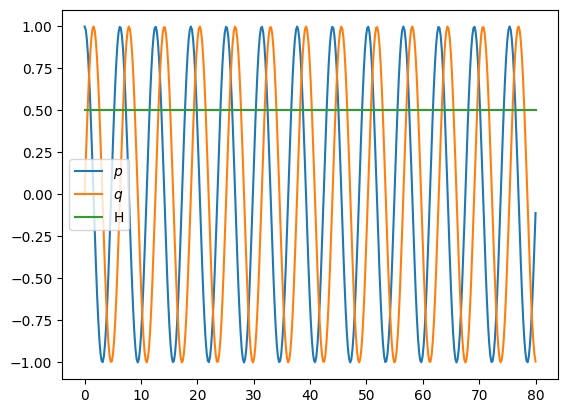

In [10]:
p, q = pq.T
H = 0.5 * (p ** 2 + q ** 2)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [11]:
rng = np.random.default_rng(42)

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

rng = np.random.default_rng(seed=42)
M = np.ones_like(X_true).astype(bool)
sparse_mask = rng.choice([False, True], p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR], size=OBSERVATIONS_END)
M[:OBSERVATIONS_END, 1] = sparse_mask
M[:OBSERVATIONS_END, 2] = sparse_mask
M[OBSERVATIONS_END:, 1:3] = False
M[:, 3] = False

rng = np.random.default_rng(42)
#X = rng.uniform(-0.15, 0.15, size=X_true.shape)
X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]

In [12]:
ms_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

ms_graph.add_observable("t")
ms_graph.add_unknown_fn("t", "q", alpha=P_KERNEL_NUGGET, kernel=P_KERNEL, kernel_parameters=P_KERNEL_PARAMS)
ms_graph.add_unknown_fn("t", "p", alpha=Q_KERNEL_NUGGET, kernel=Q_KERNEL, kernel_parameters=Q_KERNEL_PARAMS)

ms_graph.add_known_fn("p", "p_dot", derivative)
ms_graph.add_known_fn("q", "q_dot", derivative)
ms_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

ms_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

ms_graph.add_aggregator(["p", "q"], "pq")
ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=H_KERNEL_NUGGET, kernel=H_KERNEL, kernel_parameters=H_KERNEL_PARAMS)
ms_graph.add_known_fn("H", "grad_H", derivative)

ms_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
ms_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

ms_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
ms_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [13]:
if KFLOW_LEARNING:
    print("Running Kernel Flows to learn the parameters of the kernels.")
    run_kflow_for(ms_graph, X, M, OBSERVATIONS_END)
else:
    print("Skipping Kernel Flows Learning")

Skipping Kernel Flows Learning


In [14]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(ms_graph, X, M, OBSERVATIONS_END)

In [15]:
two_steps_mse_p = mse(X_true[OBSERVATIONS_END:, 1], X_init[OBSERVATIONS_END:, 1])
two_steps_mse_q = mse(X_true[OBSERVATIONS_END:, 2], X_init[OBSERVATIONS_END:, 2])

two_steps_re_p = relative_error(X_true[OBSERVATIONS_END:, 1], X_init[OBSERVATIONS_END:, 1]) * 100
two_steps_re_q = relative_error(X_true[OBSERVATIONS_END:, 2], X_init[OBSERVATIONS_END:, 2]) * 100

pd.DataFrame({"P": [two_steps_mse_p, two_steps_re_p], "Q": [two_steps_mse_q, two_steps_re_q]}, index=["MSE", "Relative"])

P                     Q
MSE        0.00606961650318634   0.00590443247137810
Relative  11.69740471429316919  11.58720739400980904

In [16]:
ms_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [17]:
Z = ms_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 1489.7847:   1%|          | 6405/1000000 [05:20<13:47:54, 20.00it/s]


## CGC Extrapolation

In [18]:
one_step_mse_p = mse(X_true[OBSERVATIONS_END:, 1], Z[OBSERVATIONS_END:, 1])
one_step_mse_q = mse(X_true[OBSERVATIONS_END:, 2], Z[OBSERVATIONS_END:, 2])

one_step_re_p = relative_error(X_true[OBSERVATIONS_END:, 1], Z[OBSERVATIONS_END:, 1]) * 100
one_step_re_q = relative_error(X_true[OBSERVATIONS_END:, 2], Z[OBSERVATIONS_END:, 2]) * 100

pd.DataFrame({"P": [one_step_mse_p, one_step_re_p], "Q": [one_step_mse_q, one_step_re_q]}, index=["MSE", "Relative"]) 

P                     Q
MSE       0.001766342234363374  0.001805649940788486
Relative   6.61191611807675361   6.95860695517554895

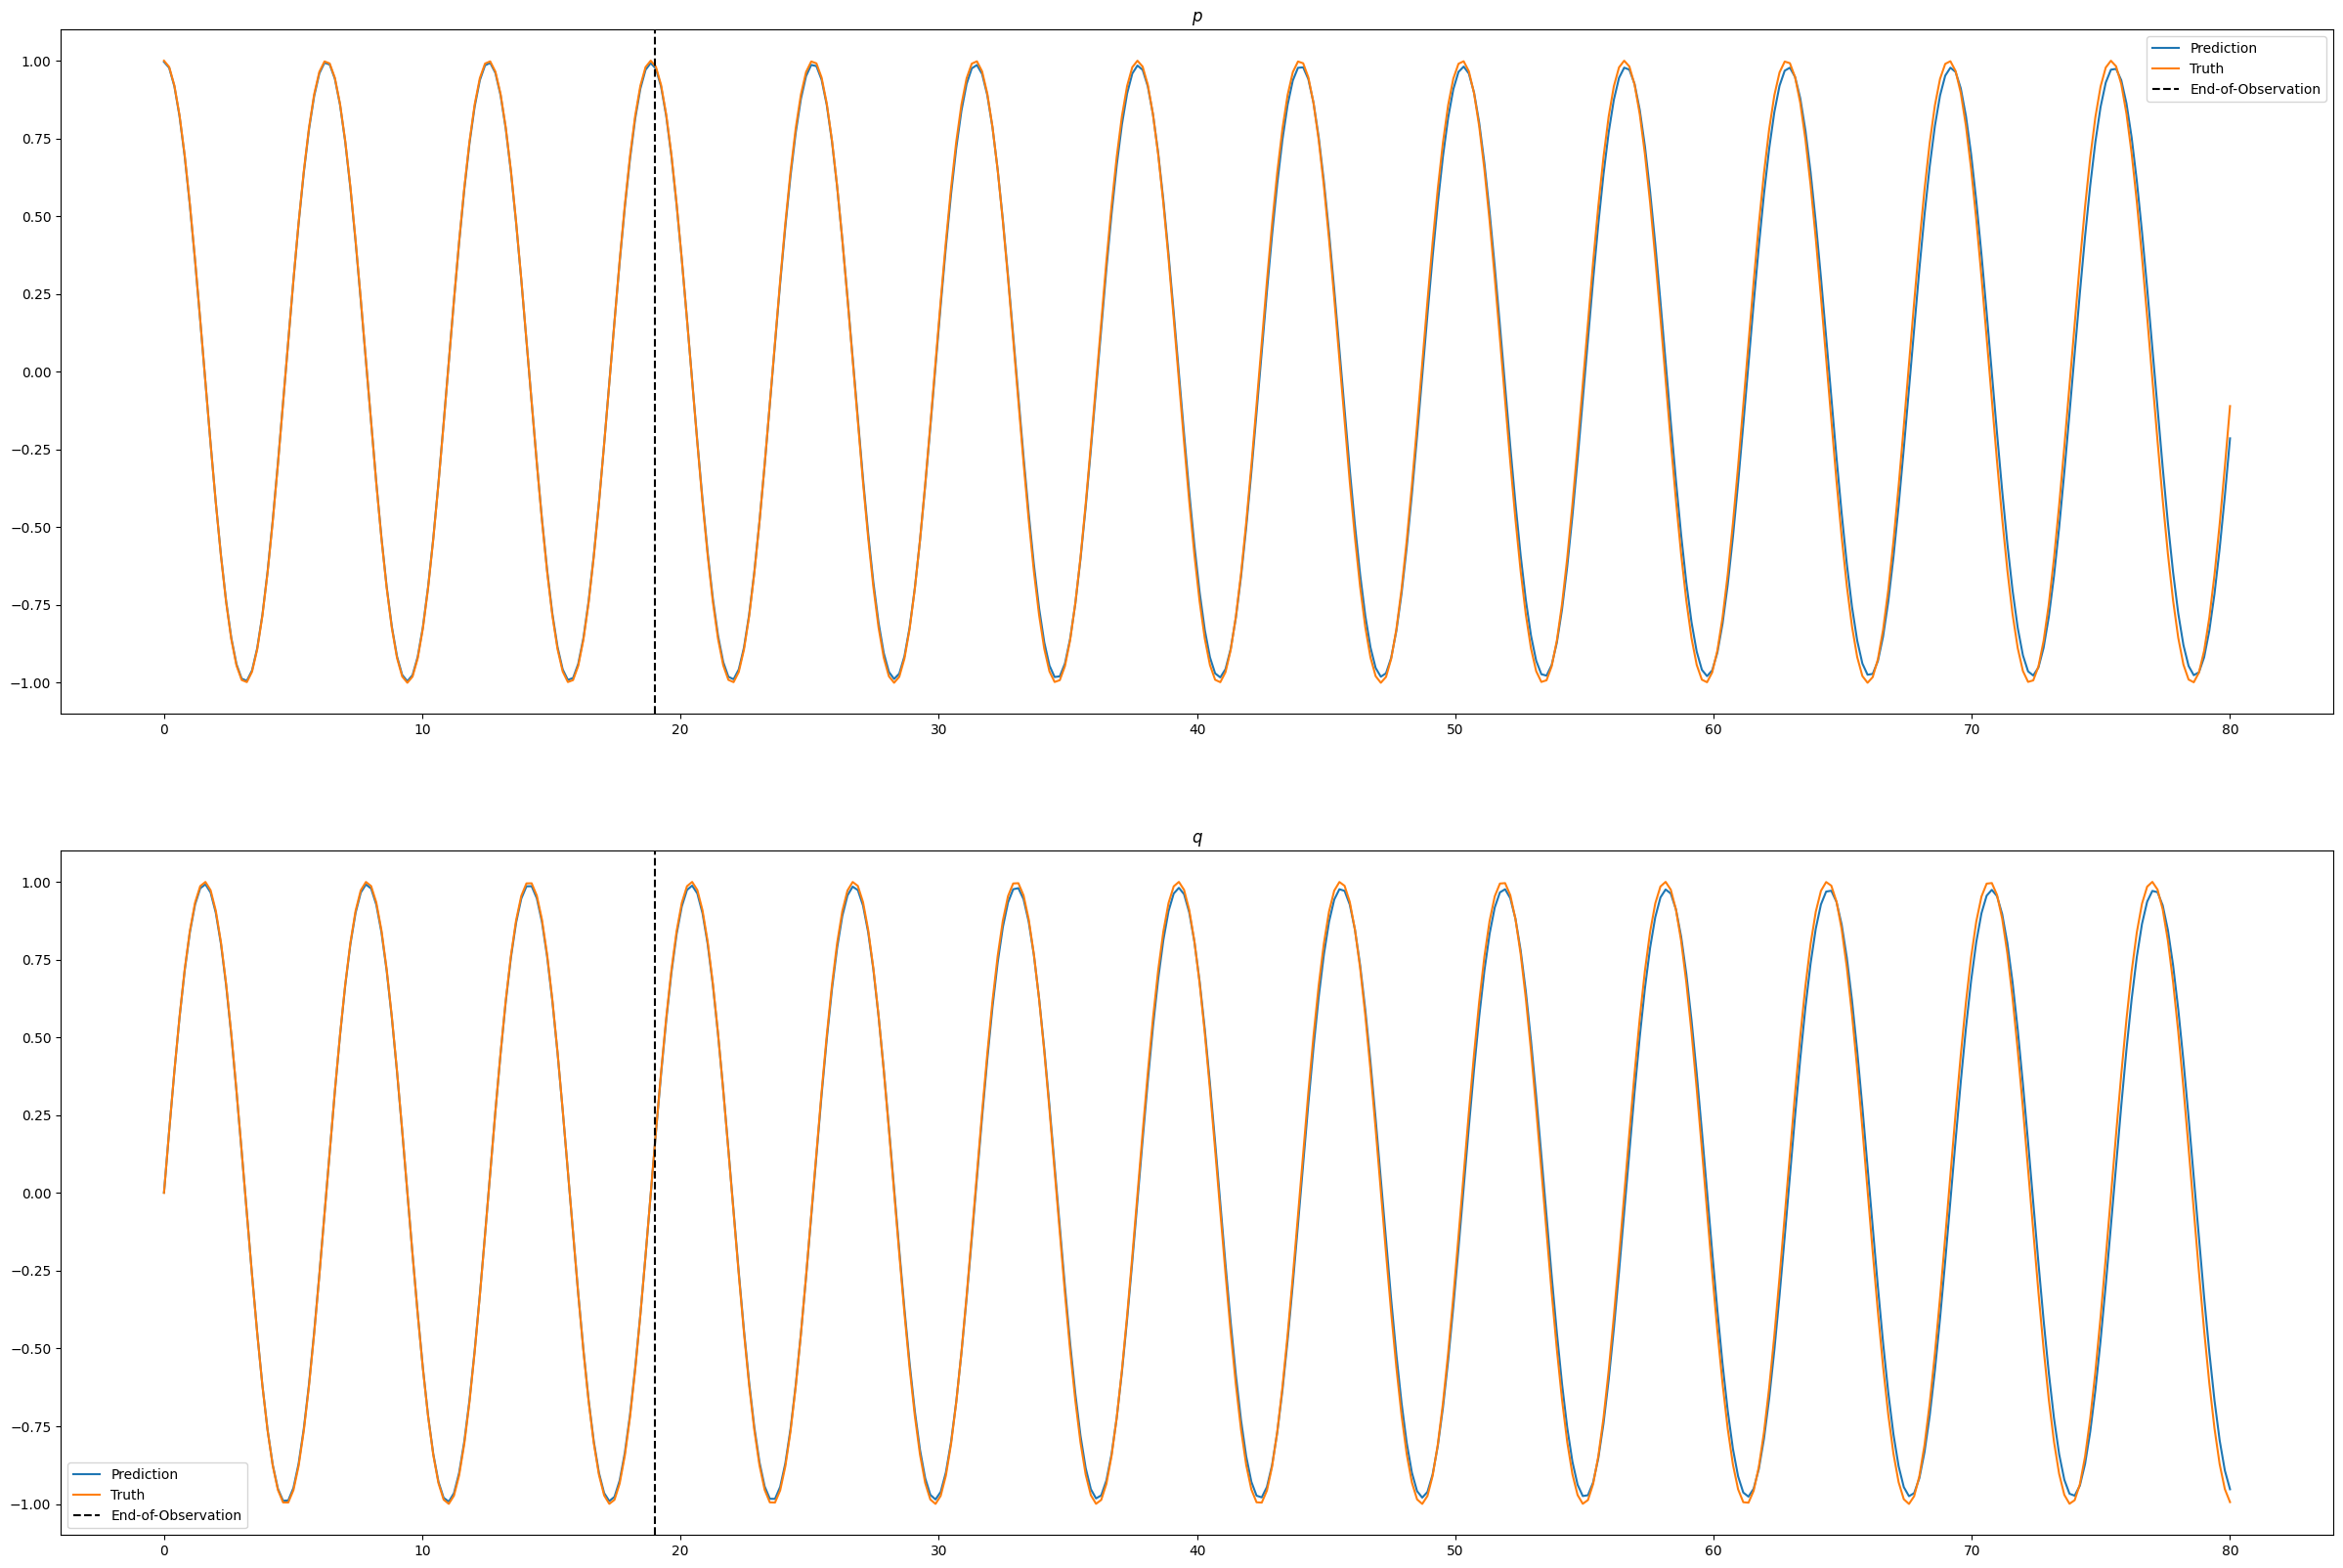

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

# Two-Mass-Three-Springs System

## Data Generation

In [20]:
def m2s3_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 + (q2 - q1),
        -q2 - (q2 - q1),
        p1,
        p2
    ]
    
    return h_grad

t = np.linspace(0, T_MAX, N)
pq = odeint(m2s3_system_ode, [0.1, -0.1, 0.2, -0.1], t)

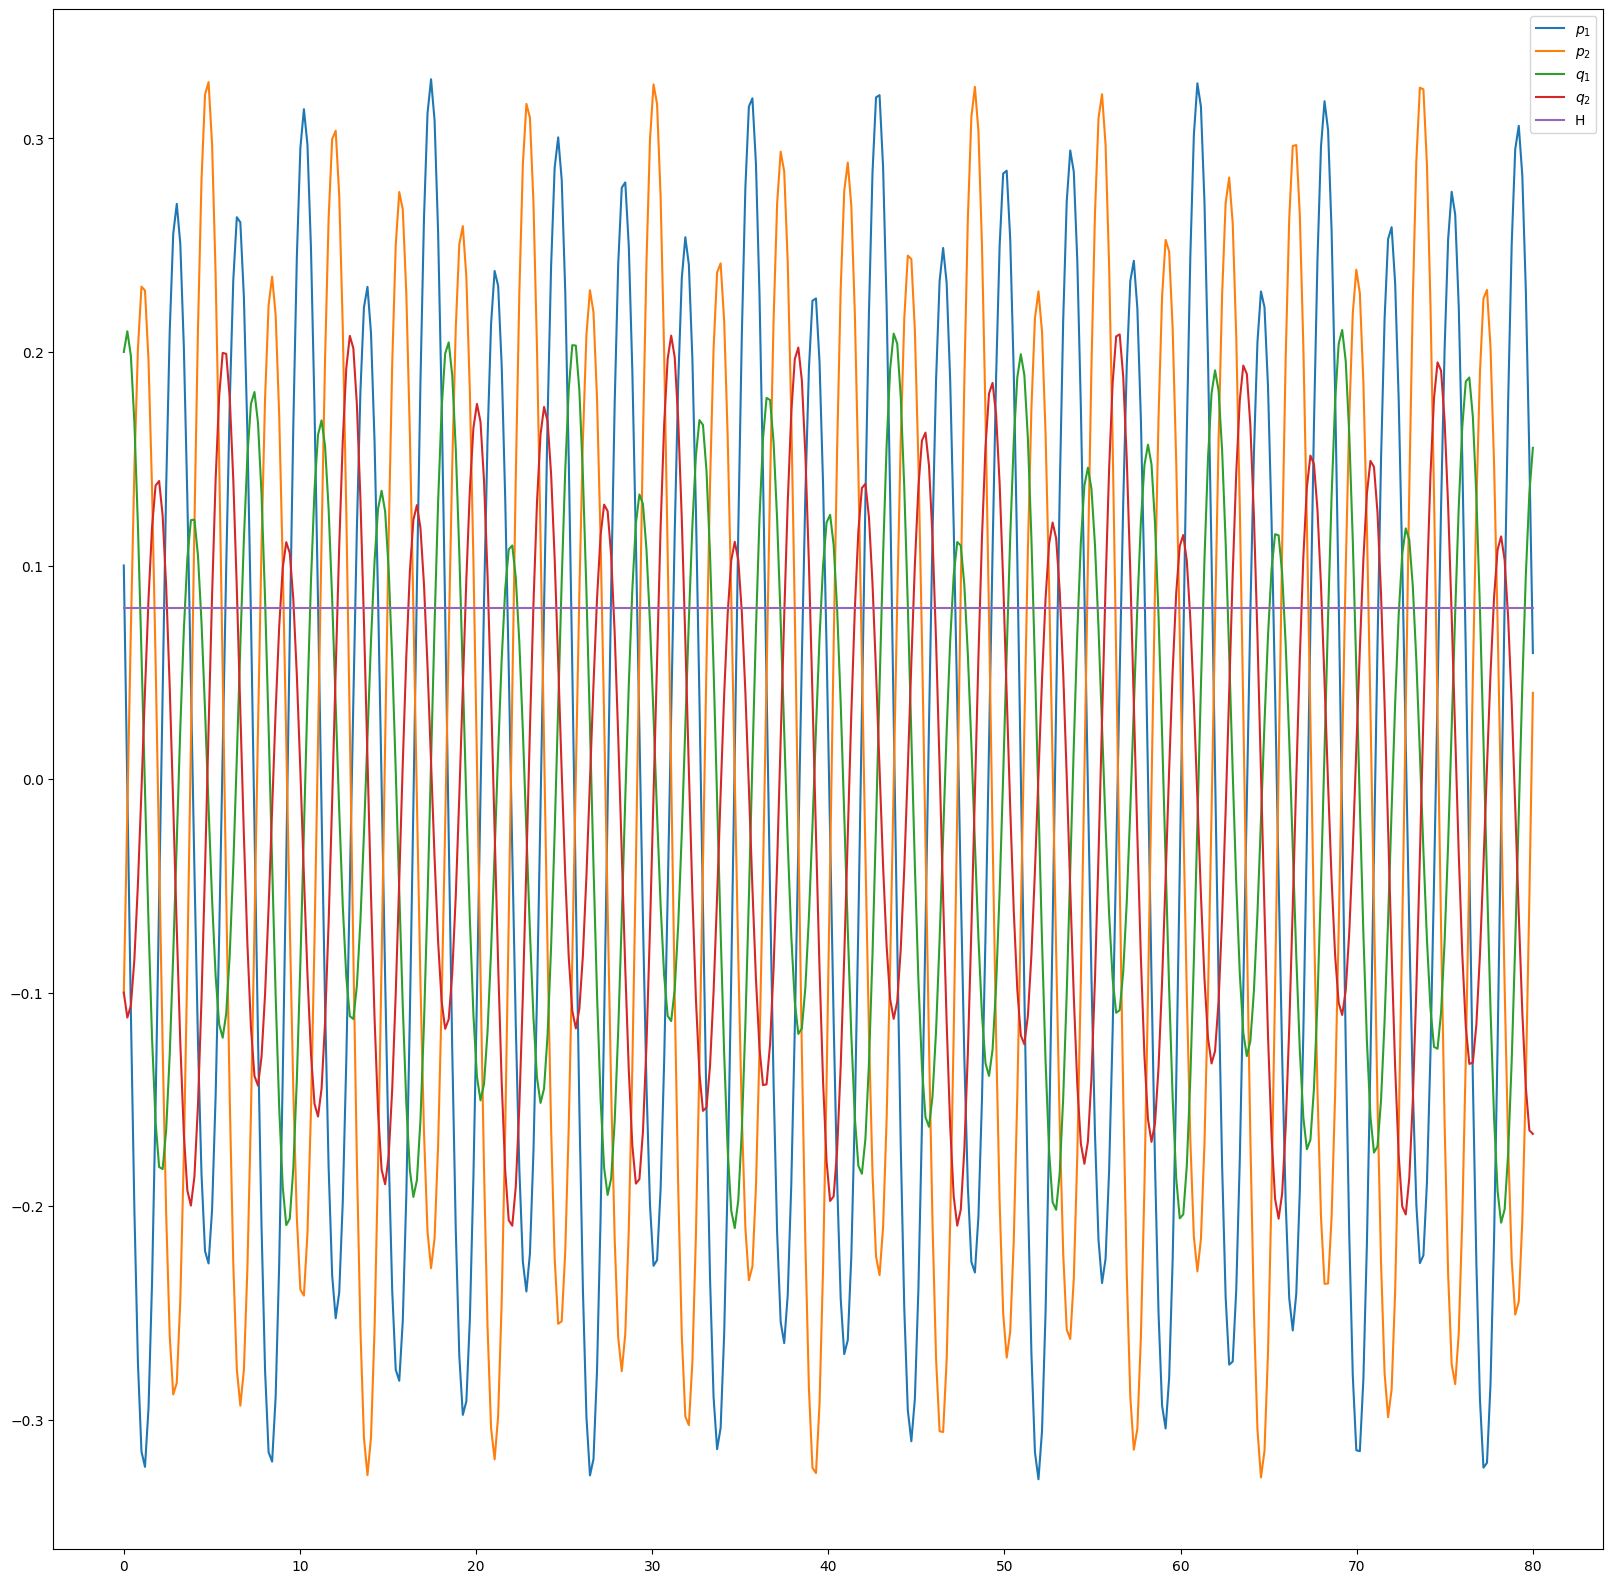

In [21]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + (q2 - q1) ** 2 + p1 ** 2 + p2 ** 2)
plt.figure(figsize=(20, 20))
plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [22]:
X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

rng = np.random.default_rng(seed=42)
observations_mask = rng.choice([False, True], size=OBSERVATIONS_END, p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR])

M = np.ones_like(X_true).astype(bool)
for i in range(1, 5):
    M[:OBSERVATIONS_END:, i] = observations_mask
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [23]:
rng = np.random.default_rng(seed=42)

m2s3_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

m2s3_graph.add_observable("t")

m2s3_graph.add_unknown_fn("t", "p1", alpha=P_KERNEL_NUGGET, kernel=P_KERNEL, kernel_parameters=P_KERNEL_PARAMS)
m2s3_graph.add_unknown_fn("t", "p2", alpha=P_KERNEL_NUGGET, kernel=P_KERNEL, kernel_parameters=P_KERNEL_PARAMS)
m2s3_graph.add_unknown_fn("t", "q1", alpha=Q_KERNEL_NUGGET, kernel=Q_KERNEL, kernel_parameters=Q_KERNEL_PARAMS)
m2s3_graph.add_unknown_fn("t", "q2", alpha=Q_KERNEL_NUGGET, kernel=Q_KERNEL, kernel_parameters=Q_KERNEL_PARAMS)


m2s3_graph.add_known_fn("p1", "p1_dot", derivative)
m2s3_graph.add_known_fn("p2", "p2_dot", derivative)
m2s3_graph.add_known_fn("q1", "q1_dot", derivative)
m2s3_graph.add_known_fn("q2", "q2_dot", derivative)

m2s3_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
m2s3_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
m2s3_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

m2s3_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
m2s3_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=H_KERNEL_NUGGET, kernel=H_KERNEL, kernel_parameters=H_KERNEL_PARAMS)

m2s3_graph.add_known_fn("H", "grad_H", derivative)

m2s3_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

m2s3_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

m2s3_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
m2s3_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [24]:
if KFLOW_LEARNING:
    print("Running Kernel Flows to learn the parameters of the kernels.")
    run_kflow_for(m2s3_graph, X, M, OBSERVATIONS_END)
else:
    print("Skipping Kernel Flows Learning")

Skipping Kernel Flows Learning


In [25]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(m2s3_graph, X, M, OBSERVATIONS_END)

In [26]:
two_steps_mse_p = mse(X_true[OBSERVATIONS_END:, 1:3], X_init[OBSERVATIONS_END:, 1:3])
two_steps_mse_q = mse(X_true[OBSERVATIONS_END:, 3:5], X_init[OBSERVATIONS_END:, 3:5])

two_steps_re_p = relative_error(X_true[OBSERVATIONS_END:, 1:3], X_init[OBSERVATIONS_END:, 1:3]) * 100
two_steps_re_q = relative_error(X_true[OBSERVATIONS_END:, 3:5], X_init[OBSERVATIONS_END:, 3:5]) * 100

pd.DataFrame({"P": [two_steps_mse_p, two_steps_re_p], "Q": [two_steps_mse_q, two_steps_re_q]}, index=["MSE", "Relative"])

P                     Q
MSE        0.00069449726496752   0.00025582653029098
Relative  13.41026235958330304  13.22543759391039941

In [27]:
m2s3_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [28]:
Z = m2s3_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 69.7964:   1%|          | 8513/1000000 [15:53<30:50:04,  8.93it/s]


## CGC Extrapolation

In [29]:
one_step_mse_p = mse(X_true[OBSERVATIONS_END:, 1:3], Z[OBSERVATIONS_END:, 1:3])
one_step_mse_q = mse(X_true[OBSERVATIONS_END:, 3:5], Z[OBSERVATIONS_END:, 3:5])

one_step_re_p = relative_error(X_true[OBSERVATIONS_END:, 1:3], Z[OBSERVATIONS_END:, 1:3]) * 100
one_step_re_q = relative_error(X_true[OBSERVATIONS_END:, 3:5], Z[OBSERVATIONS_END:, 3:5]) * 100

pd.DataFrame({"P": [one_step_mse_p, one_step_re_p], "Q": [one_step_mse_q, one_step_re_q]}, index=["MSE", "Relative"]) 

P                      Q
MSE       0.00019665617955281413  6.134378974938039e-05
Relative     5.40329896483801342    5.02607689982928818

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(19, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Hénon–Heiles System

## Data Generation

In [31]:
def hh_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 - 2 * q1 * q2,
        -q2 - q1 ** 2 + q2 ** 2,
        p1,
        p2
    ]

    return h_grad

t = np.linspace(0, T_MAX, N)
pq = odeint(hh_system_ode, [0.1, -0.1, 0.2, -0.1], t)


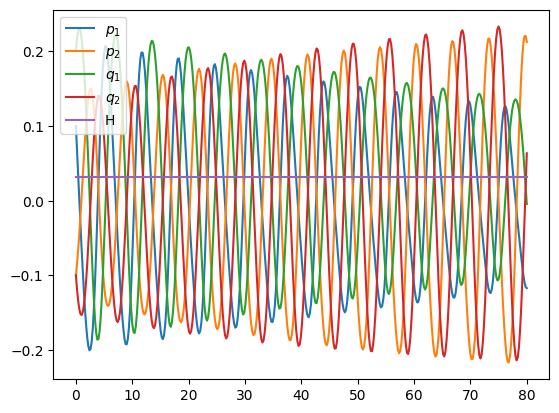

In [32]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + p1 ** 2 + p2 ** 2) + q2 * q1 ** 2 - (1/3) * q2 ** 3

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [33]:
X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

rng = np.random.default_rng(seed=42)
observations_mask = rng.choice([False, True], size=OBSERVATIONS_END, p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR])

M = np.ones_like(X_true).astype(bool)
for i in range(1, 5):
    M[:OBSERVATIONS_END:, i] = observations_mask
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [34]:
rng = np.random.default_rng(seed=42)

hh_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

hh_graph.add_observable("t")

hh_graph.add_unknown_fn("t", "p1", alpha=P_KERNEL_NUGGET, kernel=P_KERNEL, kernel_parameters=P_KERNEL_PARAMS)
hh_graph.add_unknown_fn("t", "p2", alpha=P_KERNEL_NUGGET, kernel=P_KERNEL, kernel_parameters=P_KERNEL_PARAMS)
hh_graph.add_unknown_fn("t", "q1", alpha=Q_KERNEL_NUGGET, kernel=Q_KERNEL, kernel_parameters=Q_KERNEL_PARAMS)
hh_graph.add_unknown_fn("t", "q2", alpha=Q_KERNEL_NUGGET, kernel=Q_KERNEL, kernel_parameters=Q_KERNEL_PARAMS)


hh_graph.add_known_fn("p1", "p1_dot", derivative)
hh_graph.add_known_fn("p2", "p2_dot", derivative)
hh_graph.add_known_fn("q1", "q1_dot", derivative)
hh_graph.add_known_fn("q2", "q2_dot", derivative)

hh_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
hh_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
hh_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

hh_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
hh_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

hh_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=H_KERNEL_NUGGET, kernel=H_KERNEL, kernel_parameters=H_KERNEL_PARAMS)
hh_graph.add_known_fn("H", "grad_H", derivative)

hh_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

hh_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

hh_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
hh_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [35]:
if KFLOW_LEARNING:
    print("Running Kernel Flows to learn the parameters of the kernels.")
    run_kflow_for(hh_graph, X, M, OBSERVATIONS_END)
else:
    print("Skipping Kernel Flows Learning")

Skipping Kernel Flows Learning


In [36]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(hh_graph, X, M, OBSERVATIONS_END)

In [37]:
two_steps_mse_p = mse(X_true[OBSERVATIONS_END:, 1:3], X_init[OBSERVATIONS_END:, 1:3])
two_steps_mse_q = mse(X_true[OBSERVATIONS_END:, 3:5], X_init[OBSERVATIONS_END:, 3:5])

two_steps_re_p = relative_error(X_true[OBSERVATIONS_END:, 1:3], X_init[OBSERVATIONS_END:, 1:3]) * 100
two_steps_re_q = relative_error(X_true[OBSERVATIONS_END:, 3:5], X_init[OBSERVATIONS_END:, 3:5]) * 100

pd.DataFrame({"P": [two_steps_mse_p, two_steps_re_p], "Q": [two_steps_mse_q, two_steps_re_q]}, index=["MSE", "Relative"])

P                     Q
MSE        0.00212427780202546   0.00237899985292490
Relative  25.55552311643048569  25.53321563972627573

In [38]:
hh_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [39]:
Z = hh_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 2.9013:   1%|          | 7941/1000000 [14:06<29:21:57,  9.38it/s]


## CGC Extrapolation

In [40]:
one_step_mse_p = mse(X_true[OBSERVATIONS_END:, 1:3], Z[OBSERVATIONS_END:, 1:3])
one_step_mse_q = mse(X_true[OBSERVATIONS_END:, 3:5], Z[OBSERVATIONS_END:, 3:5])

one_step_re_p = relative_error(X_true[OBSERVATIONS_END:, 1:3], Z[OBSERVATIONS_END:, 1:3]) * 100
one_step_re_q = relative_error(X_true[OBSERVATIONS_END:, 3:5], Z[OBSERVATIONS_END:, 3:5]) * 100

pd.DataFrame({"P": [one_step_mse_p, one_step_re_p], "Q": [one_step_mse_q, one_step_re_q]}, index=["MSE", "Relative"]) 

P                      Q
MSE       0.0016059062336801376  0.0017566532652110685
Relative   22.49021704047807901   22.34795284640480872

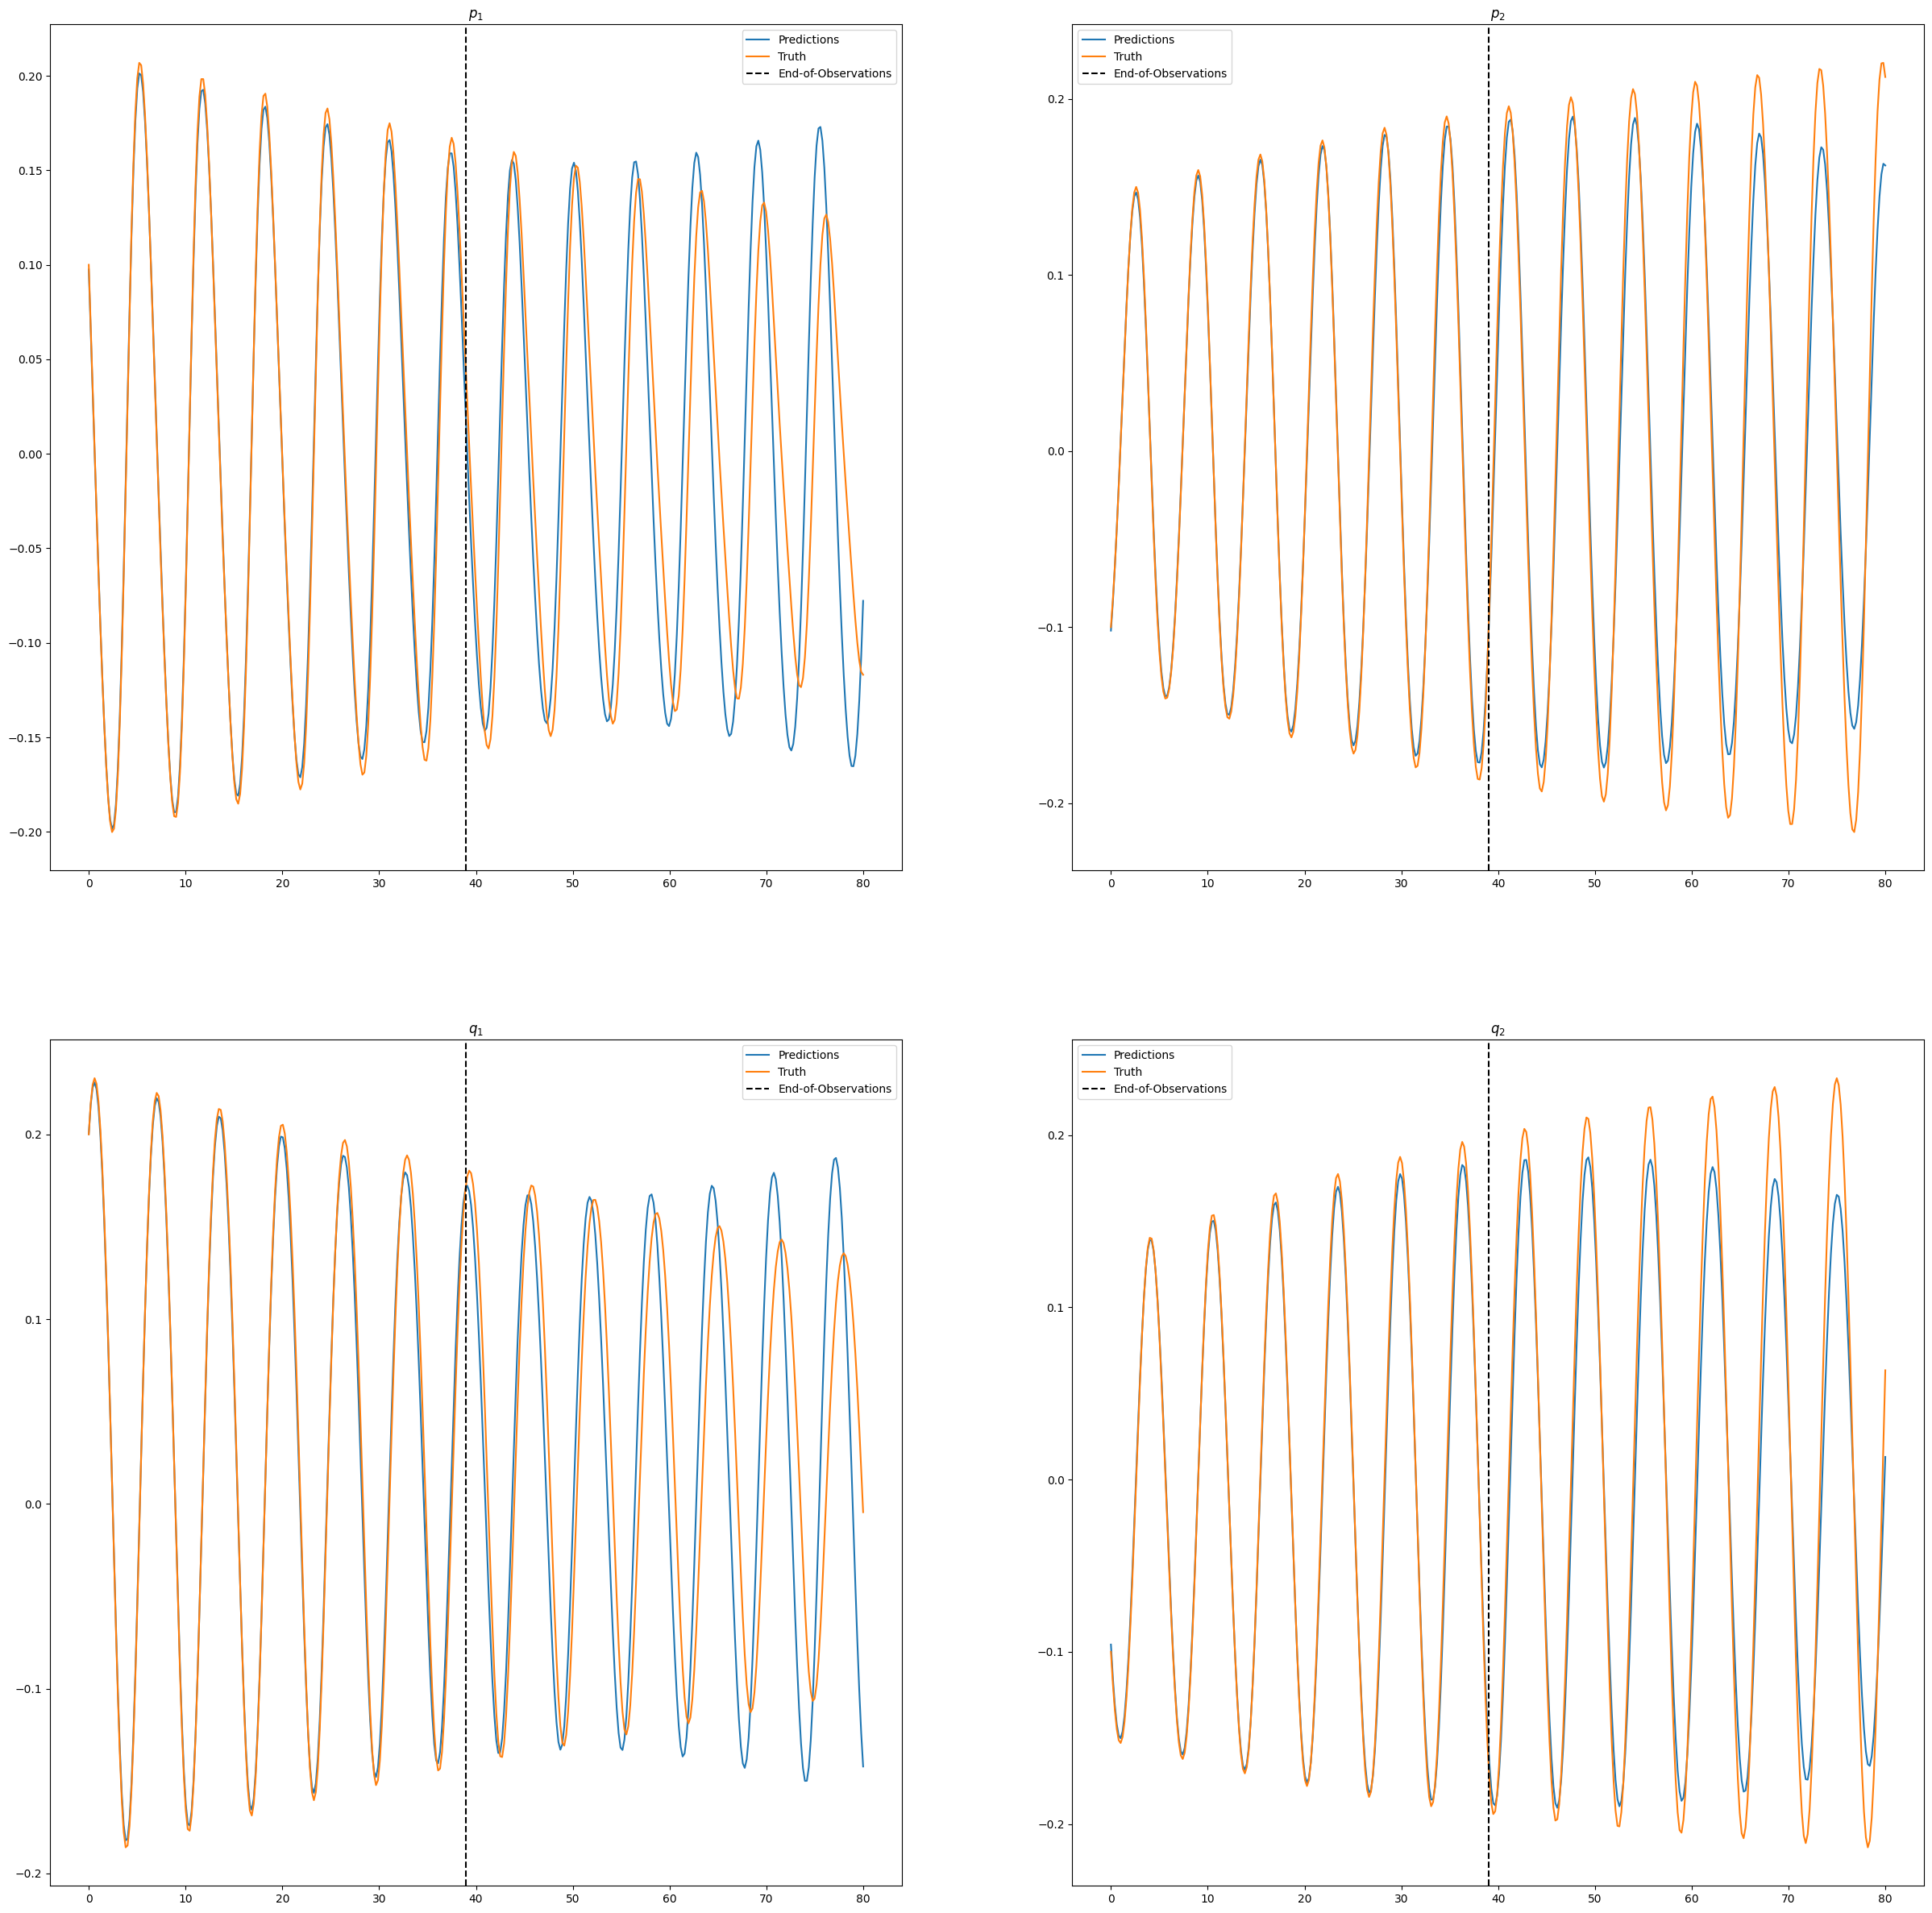

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Nonliner Pendulum

## Data Generation

In [42]:
def H(p, q):
    return (0.5 * p ** 2) - jnp.cos(q)

def system_ode(pq, t):
    h_grad = [0, 0]
    p, q = pq
    h_grad[0] = -jnp.sin(q)
    h_grad[1] = p
    return h_grad

t = np.linspace(0, T_MAX, N)
pq = odeint(system_ode, [0.0, 0.95*np.pi], t=t)

In [43]:
p, q = pq.T
H = H(p, q)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [44]:
rng = np.random.default_rng(42)

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

rng = np.random.default_rng(seed=42)
M = np.ones_like(X_true).astype(bool)
sparse_mask = rng.choice([False, True], p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR], size=OBSERVATIONS_END)
M[:OBSERVATIONS_END, 1] = sparse_mask
M[:OBSERVATIONS_END, 2] = sparse_mask
M[OBSERVATIONS_END:, 1:3] = False
M[:, 3] = False

rng = np.random.default_rng(42)
#X = rng.uniform(-0.15, 0.15, size=X_true.shape)
X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]

In [45]:
np_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

np_graph.add_observable("t")
np_graph.add_unknown_fn("t", "q", alpha=P_KERNEL_NUGGET, kernel=P_KERNEL, kernel_parameters=P_KERNEL_PARAMS)
np_graph.add_unknown_fn("t", "p", alpha=Q_KERNEL_NUGGET, kernel=Q_KERNEL, kernel_parameters=Q_KERNEL_PARAMS)

np_graph.add_known_fn("p", "p_dot", derivative)
np_graph.add_known_fn("q", "q_dot", derivative)
np_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

np_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

np_graph.add_aggregator(["p", "q"], "pq")
np_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=H_KERNEL_NUGGET, kernel=H_KERNEL, kernel_parameters=H_KERNEL_PARAMS)
np_graph.add_known_fn("H", "grad_H", derivative)

np_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
np_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

np_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
np_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [46]:
if KFLOW_LEARNING:
    print("Running Kernel Flows to learn the parameters of the kernels.")
    run_kflow_for(np_graph, X, M, OBSERVATIONS_END)
else:
    print("Skipping Kernel Flows Learning")

Skipping Kernel Flows Learning


In [47]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(np_graph, X, M, OBSERVATIONS_END)

In [48]:
two_steps_mse_p = mse(X_true[OBSERVATIONS_END:, 1], X_init[OBSERVATIONS_END:, 1])
two_steps_mse_q = mse(X_true[OBSERVATIONS_END:, 2], X_init[OBSERVATIONS_END:, 2])

two_steps_re_p = relative_error(X_true[OBSERVATIONS_END:, 1], X_init[OBSERVATIONS_END:, 1]) * 100
two_steps_re_q = relative_error(X_true[OBSERVATIONS_END:, 2], X_init[OBSERVATIONS_END:, 2]) * 100

pd.DataFrame({"P": [two_steps_mse_p, two_steps_re_p], "Q": [two_steps_mse_q, two_steps_re_q]}, index=["MSE", "Relative"])

P                     Q
MSE        0.51997845851405156   2.03135581459581882
Relative  50.43889801550861307  29.67582759733232578

In [49]:
np_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [50]:
Z = np_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 48912.6146:   1%|▏         | 13327/1000000 [11:20<14:00:16, 19.57it/s]


## CGC Extrapolation

In [51]:
one_step_mse_p = mse(X_true[OBSERVATIONS_END:, 1], Z[OBSERVATIONS_END:, 1])
one_step_mse_q = mse(X_true[OBSERVATIONS_END:, 2], Z[OBSERVATIONS_END:, 2])

one_step_re_p = relative_error(X_true[OBSERVATIONS_END:, 1], Z[OBSERVATIONS_END:, 1]) * 100
one_step_re_q = relative_error(X_true[OBSERVATIONS_END:, 2], Z[OBSERVATIONS_END:, 2]) * 100

pd.DataFrame({"P": [one_step_mse_p, one_step_re_p], "Q": [one_step_mse_q, one_step_re_q]}, index=["MSE", "Relative"]) 

P                     Q
MSE         0.4762805587818393    1.8068908290750005
Relative  46.46918516135606581  27.45239430849120765

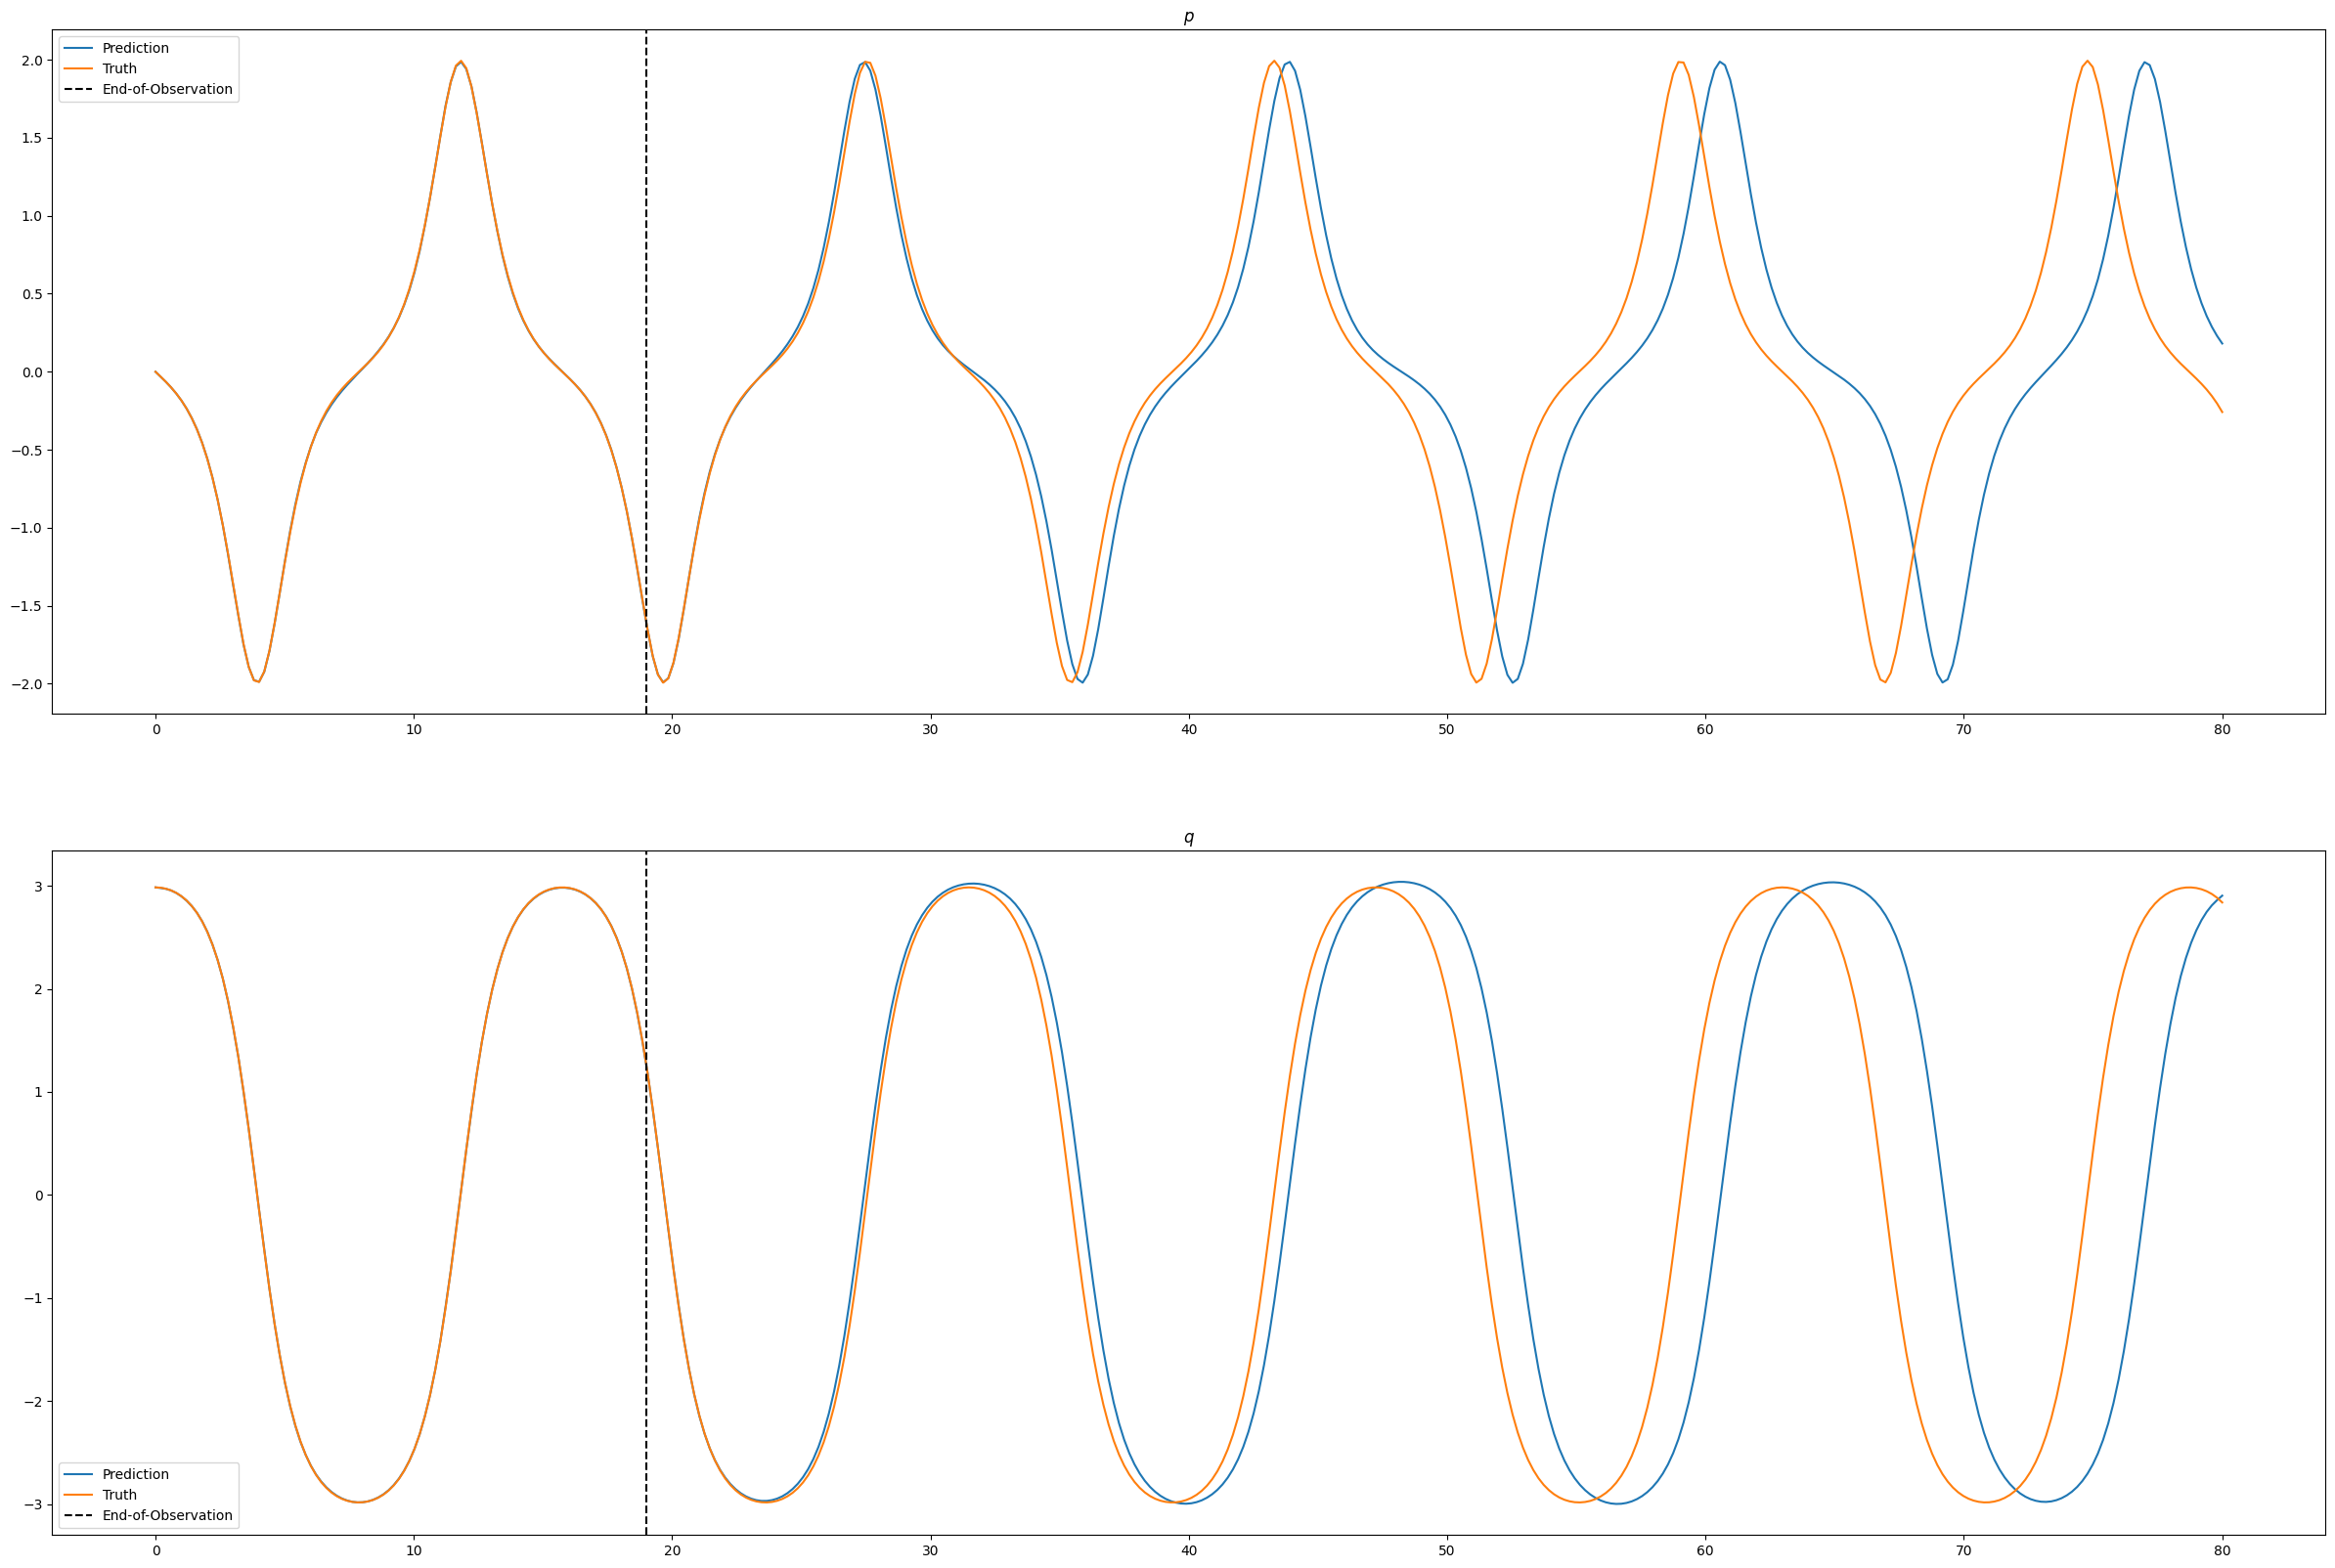

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()